Import Library

In [37]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Unduh stopwords jika belum
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rebecca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read and Print Data

In [26]:
# Baca file CSV
df = pd.read_csv('data/google-play-rev-gen-2.csv')

print(df.columns)

# Tampilkan isi kolom 'Nama'
df.head(10)

Index(['id', 'title', 'avatar', 'rating', 'snippet', 'likes', 'date',
       'iso_date', 'response'],
      dtype='object')


,id,title,avatar,rating,snippet,likes,date,iso_date,response
0,e5384431-56f9-43fa-a32a-53296afc7f66,Seraphim,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,"While I've reviewed this before, I decided to ...",88,"October 09, 2024",2024-10-09T00:08:20Z,NaN
1,6a73081f-3490-47ba-89fa-83744cb20940,TWOSTORE !,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,Very fun but I wish there was more fighting in...,35,"October 12, 2024",2024-10-12T06:39:01Z,NaN
2,3a3d4c90-0b6e-45dc-b1e6-014659055bbf,A G,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,"Fun game, I enjoy the story. There is tons to ...",11,"October 30, 2024",2024-10-30T18:01:37Z,NaN
3,99015538-1d26-4bd9-a02f-37bc2a361d1a,Astra,https://play-lh.googleusercontent.com/a-/ALV-U...,5.0,This game is phenomenal. The art style and sce...,77,"October 18, 2024",2024-10-18T19:11:12Z,NaN
4,541b3b4d-97f6-42e0-9c68-059a63e1e67f,Angela Williams,https://play-lh.googleusercontent.com/a-/ALV-U...,2.0,"I love this game. However, it is incredibly la...",14,"October 14, 2024",2024-10-14T03:04:43Z,NaN
5,ad484b6a-1b9c-42ab-9cee-9df6e28f12d4,Valerie,https://play-lh.googleusercontent.com/a-/ALV-U...,3.0,I used to be obsessed with this game but I hav...,99,"October 13, 2024",2024-10-13T14:02:08Z,NaN
6,fb25cdf6-40d8-44e8-b1b9-d439ebd88565,Daniel “Chotara” Ricciardi,https://play-lh.googleusercontent.com/a-/ALV-U...,5.0,Highly recommend. I have been playing the game...,65,"October 18, 2024",2024-10-18T15:20:11Z,NaN
7,36e821d3-9441-4eaa-94a7-9c7b9b7463b5,Amy,https://play-lh.googleusercontent.com/a-/ALV-U...,4.0,Hello! I absolutely love this game! It has inc...,29,"October 29, 2024",2024-10-29T00:27:08Z,NaN
8,4b1e6dcb-d251-450e-9be6-358b4bb8e9d6,Feitan Desy,https://play-lh.googleusercontent.com/a-/ALV-U...,4.0,I've been playing this game since January 16th...,64,"October 08, 2024",2024-10-08T23:13:09Z,NaN
9,27525772-1c0a-40e4-8321-4c5f0a0f7c64,Olivia Staringer,https://play-lh.googleusercontent.com/a-/ALV-U...,1.0,"Uninteresting characters, uninteresting dialog...",14,"November 11, 2024",2024-11-11T22:58:07Z,NaN


Inisialisasi stopwords dan stemmer

In [31]:
# Inisialisasi stopwords dan stemmer
stop_words = list(stopwords.words('english'))  # Mengonversi set menjadi list
stemmer = SnowballStemmer('english')

Preprocessing

In [32]:
# Preprocessing function
def preprocess_text(text):
    # Menghapus karakter khusus, angka, dan tanda baca
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenisasi: Pisahkan teks menjadi list kata
    tokens = text.lower().split()
    
    # Menghapus stopwords dan stemming
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Gabungkan kembali tokens yang telah diproses menjadi teks yang bersih
    return ' '.join(processed_tokens)

# Pastikan nama kolom 'snippet' sesuai dengan data yang ada
# Terapkan preprocessing pada kolom 'snippet' yang berisi ulasan
df['cleaned_snippet'] = df['snippet'].apply(preprocess_text)

# Tampilkan contoh hasil setelah preprocessing
print(df[['snippet', 'cleaned_snippet']].head(10))

                                             snippet  \
0  While I've reviewed this before, I decided to ...   
1  Very fun but I wish there was more fighting in...   
2  Fun game, I enjoy the story. There is tons to ...   
3  This game is phenomenal. The art style and sce...   
4  I love this game. However, it is incredibly la...   
5  I used to be obsessed with this game but I hav...   
6  Highly recommend. I have been playing the game...   
7  Hello! I absolutely love this game! It has inc...   
8  I've been playing this game since January 16th...   
9  Uninteresting characters, uninteresting dialog...   

                                     cleaned_snippet  
0  ive review decid edit respons current opinion ...  
1  fun wish fight quest bunch talk run around com...  
2  fun game enjoy stori ton ton content clear you...  
3  game phenomen art style sceneri stun yes game ...  
4  love game howev incred laggi point unplay grap...  
5  use obsess game havent play month bore repetit... 

Keyword Extraction TF-IDF

In [33]:
# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words)  # Menggunakan list stopwords

# Fit dan transform data ulasan yang telah diproses menggunakan TF-IDF
X_tfidf = vectorizer.fit_transform(df['cleaned_snippet'])  # Gunakan 'cleaned_snippet' yang sudah diproses

# Ambil fitur kata kunci dari hasil TF-IDF
tfidf_features = vectorizer.get_feature_names_out()

# Konversi hasil TF-IDF menjadi DataFrame agar lebih mudah dibaca
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_features)

# Menampilkan hasil TF-IDF
print(tfidf_df.head())

       abil       abl  absolut  absurd  abt  abyss  acc  accept  accident  \
0  0.000000  0.000000      0.0     0.0  0.0    0.0  0.0     0.0       0.0   
1  0.214096  0.000000      0.0     0.0  0.0    0.0  0.0     0.0       0.0   
2  0.000000  0.188446      0.0     0.0  0.0    0.0  0.0     0.0       0.0   
3  0.000000  0.000000      0.0     0.0  0.0    0.0  0.0     0.0       0.0   
4  0.000000  0.000000      0.0     0.0  0.0    0.0  0.0     0.0       0.0   

   accommod  ...  yep       yes  yesterday       yet  youll  youtub  youv  \
0       0.0  ...  0.0  0.000000        0.0  0.000000    0.0     0.0   0.0   
1       0.0  ...  0.0  0.000000        0.0  0.000000    0.0     0.0   0.0   
2       0.0  ...  0.0  0.000000        0.0  0.000000    0.0     0.0   0.0   
3       0.0  ...  0.0  0.201157        0.0  0.000000    0.0     0.0   0.0   
4       0.0  ...  0.0  0.000000        0.0  0.152187    0.0     0.0   0.0   

   yrs  zelda  zero  
0  0.0    0.0   0.0  
1  0.0    0.0   0.0  
2  0.0  

Menampilkan Kata Kunci Berdasarkan Skor TF-IDF


In [34]:
# Menampilkan kata-kata dengan skor TF-IDF tertinggi untuk setiap ulasan
top_n = 5  # Menampilkan 5 kata teratas untuk setiap ulasan

for i, row in tfidf_df.iterrows():
    top_keywords = row.sort_values(ascending=False).head(top_n)
    print(f"Review {i+1} top keywords:")
    print(top_keywords)
    print("-" * 40)


Review 1 top keywords:
energi     0.363088
upgrad     0.333117
struggl    0.207162
respons    0.207162
excess     0.207162
Name: 0, dtype: float64
----------------------------------------
Review 2 top keywords:
potenti    0.404501
leav       0.404501
dialogu    0.267947
skip       0.264116
bunch      0.230791
Name: 1, dtype: float64
----------------------------------------
Review 3 top keywords:
ton      0.407664
enjoy    0.329305
kill     0.251220
clear    0.237321
avail    0.237321
Name: 2, dtype: float64
----------------------------------------
Review 4 top keywords:
joy            0.229543
hatefulspam    0.229543
phenomen       0.229543
ignor          0.229543
bot            0.229543
Name: 3, dtype: float64
----------------------------------------
Review 5 top keywords:
point      0.311319
isnt       0.297985
somehow    0.223693
dent       0.223693
manag      0.223693
Name: 4, dtype: float64
----------------------------------------
Review 6 top keywords:
feedback    0.374156
chang 

Top 10 words for Topic #0:
game play better would im much give combat cant develop

Top 10 words for Topic #1:
game like play charact make year issu updat even voic

Top 10 words for Topic #2:
game charact get good play lot data quest stori realli

Top 10 words for Topic #3:
game good skip charact like button dialogu cant hour guy

Top 10 words for Topic #4:
game charact play stori like quest amaz get love realli



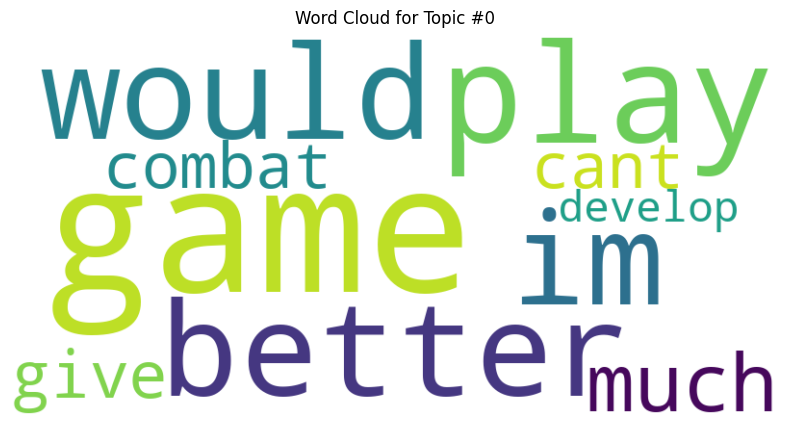

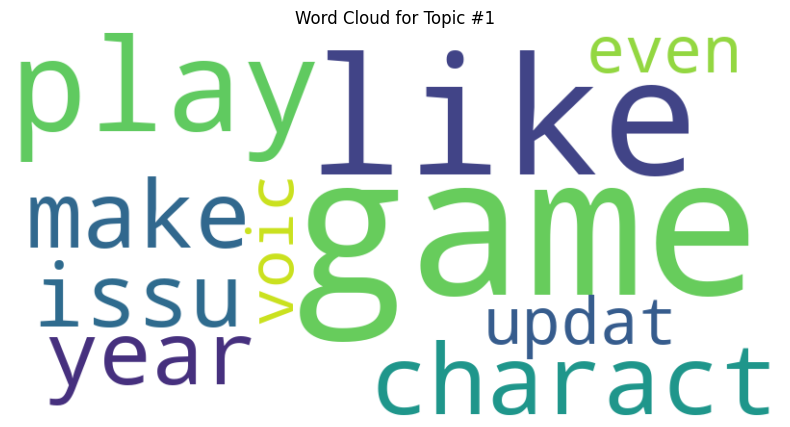

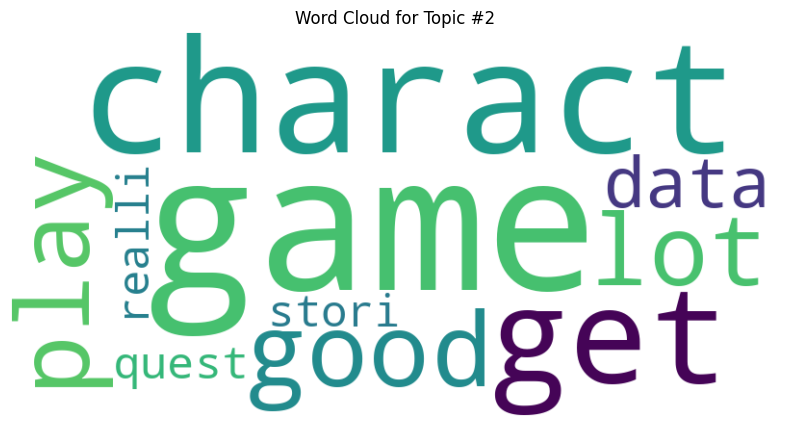

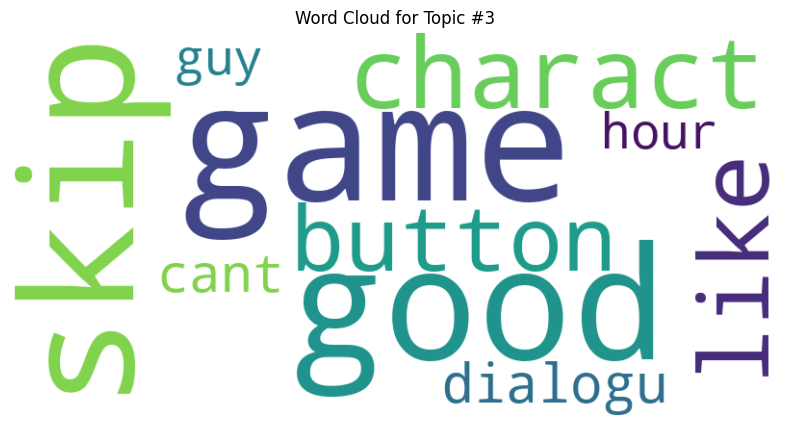

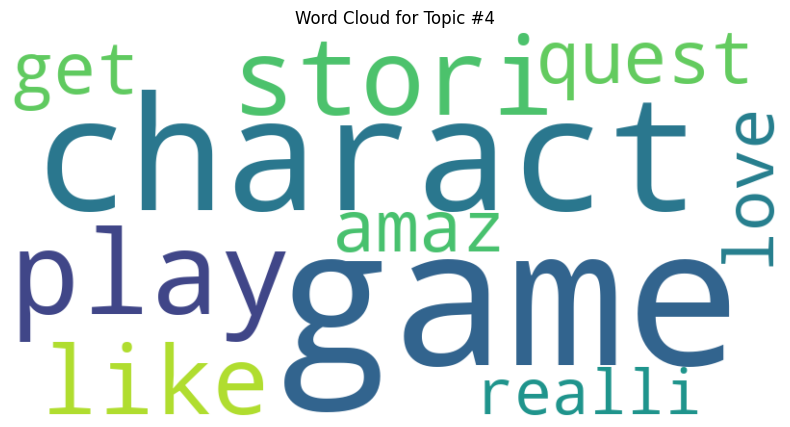

In [39]:
# ----- LDA - Latent Dirichlet Allocation untuk Identifikasi Topik -----
# Tentukan jumlah topik (misalnya, 5 topik)
num_topics = 5

# Inisialisasi model LDA
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit model LDA pada data TF-IDF
lda_model.fit(X_tfidf)

# Melihat topik-topik yang ditemukan oleh LDA
# Setiap topik memiliki distribusi kata-kata tertentu
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Top 10 words for Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

# Menampilkan top 10 kata untuk setiap topik
print_top_words(lda_model, tfidf_features, 10)

# ----- Visualisasi Word Clouds untuk Topik yang Ditemukan -----
from wordcloud import WordCloud

def plot_word_cloud_for_topic(model, topic_idx, feature_names, n_top_words=10):
    topic = model.components_[topic_idx]
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_indices]
    top_weights = topic[top_indices]

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(top_words, top_weights)))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for Topic #{topic_idx}")
    plt.axis("off")
    plt.show()

# Visualisasikan word cloud untuk setiap topik
for topic_idx in range(num_topics):
    plot_word_cloud_for_topic(lda_model, topic_idx, tfidf_features)
